# Predicting Cancer Survival Months Based on Diagnosis Data

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_columns = None

%matplotlib inline

In [2]:
# Read the dataset 
df = pd.read_csv('case_reduced_label_revised.csv')
df.head()

,Age recode with <1 year olds,Sex,Year of diagnosis,"Race recode (W, B, AI, API)","Origin recode NHIA (Hispanic, Non-Hisp)",Site recode ICD-O-3/WHO 2008,Behavior code ICD-O-3,Grade (thru 2017),Grade Clinical (2018+),Grade Pathological (2018+),...,Total number of benign/borderline tumors for patient,First malignant primary indicator,Age recode with single ages and 85+,Race/ethnicity,Patient ID,Type of Reporting Source,Median household income inflation adj to 2019,Rural-Urban Continuum Code,Regional nodes examined (1988+),Regional nodes positive (1988+)
0,40-44 years,Male,2002,White,Non-Spanish-Hispanic-Latino,Testis,Malignant,Unknown,Blank(s),Blank(s),...,0,No,44 years,White,17,Hospital inpatient/outpatient or clinic,"$75,000+",Counties in metropolitan areas ge 1 million pop,0,98
1,65-69 years,Male,2000,White,Non-Spanish-Hispanic-Latino,Rectum,Malignant,Well differentiated; Grade I,Blank(s),Blank(s),...,0,No,69 years,White,20,Hospital inpatient/outpatient or clinic,"$75,000+",Counties in metropolitan areas ge 1 million pop,10,0
2,35-39 years,Female,2008,White,Spanish-Hispanic-Latino,Rectosigmoid Junction,Malignant,Moderately differentiated; Grade II,Blank(s),Blank(s),...,0,No,39 years,White,25,Hospital inpatient/outpatient or clinic,"$75,000+",Counties in metropolitan areas ge 1 million pop,8,1
3,60-64 years,Female,2008,White,Non-Spanish-Hispanic-Latino,"Trachea, Mediastinum and Other Respiratory Organs",Malignant,Well differentiated; Grade I,Blank(s),Blank(s),...,0,No,63 years,White,41,Hospital inpatient/outpatient or clinic,"$75,000+",Counties in metropolitan areas ge 1 million pop,0,98
4,85+ years,Male,2008,White,Non-Spanish-Hispanic-Latino,Melanoma of the Skin,Malignant,Unknown,Blank(s),Blank(s),...,0,No,85+ years,White,51,Hospital inpatient/outpatient or clinic,"$75,000+",Counties in metropolitan areas ge 1 million pop,0,98


Have a look at the columns of the dataset

In [3]:
df.columns

Index(['Age recode with <1 year olds', 'Sex', 'Year of diagnosis',
       'Race recode (W, B, AI, API)',
       'Origin recode NHIA (Hispanic, Non-Hisp)',
       'Site recode ICD-O-3/WHO 2008', 'Behavior code ICD-O-3',
       'Grade (thru 2017)', 'Grade Clinical (2018+)',
       'Grade Pathological (2018+)', 'Laterality', 'Diagnostic Confirmation',
       'SEER Combined Summary Stage 2000 (2004-2017)',
       'Derived AJCC Stage Group, 6th ed (2004-2015)',
       'Derived AJCC T, 6th ed (2004-2015)',
       'Derived AJCC N, 6th ed (2004-2015)',
       'Derived AJCC M, 6th ed (2004-2015)',
       'Reason no cancer-directed surgery',
       'RX Summ--Scope Reg LN Sur (2003+)',
       'RX Summ--Surg Oth Reg/Dis (2003+)', 'CS tumor size (2004-2015)',
       'CS extension (2004-2015)', 'COD to site recode',
       'SEER cause-specific death classification', 'Survival months',
       'Survival months flag', 'COD to site rec KM',
       'Vital status recode (study cutoff used)',
       'Total

Some of the diagnosis data are available for patients with diagnosis year 2004 onwards. Then, it makes sense to filter patients with diagnosis year earlier than 2004. Also, it seems there are a number of columns which are irrelevant such as `'Type of Reporting Source','COD to site recode'`. 


In [4]:
df = df[df['Year of diagnosis']>=2004]
# df = df[df['Year of diagnosis']<=2017]

drop_columns = ['Age recode with <1 year olds', 
               'Grade Clinical (2018+)',
               'Grade Pathological (2018+)',
               'COD to site rec KM',
               'Race/ethnicity',
               'Patient ID',
               'Type of Reporting Source',
               'COD to site recode',
               ]
df.drop(columns=drop_columns,inplace=True)

In [ ]:
# Drop the duplicate rows
df.drop_duplicates(inplace=True)

# Explanatory Data Analysis

We first have a close look at the data to have a better understanding of the dataset and how to approach the problem. 

In [25]:
print(f'The number of patients in the dataset is {df.shape[0]}')

The number of patients in the dataset is 8666662


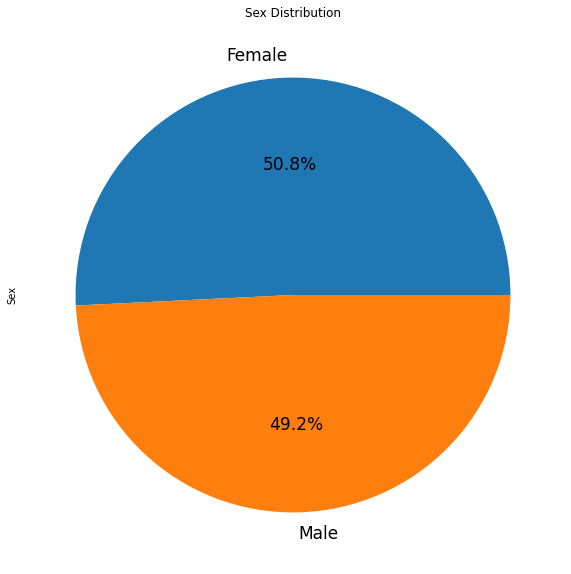

In [9]:
df['Sex'].value_counts().plot(kind='pie',
                              figsize=(15,10),
                              autopct='%1.1f%%',
                              fontsize=17,
                              title='Sex Distribution');

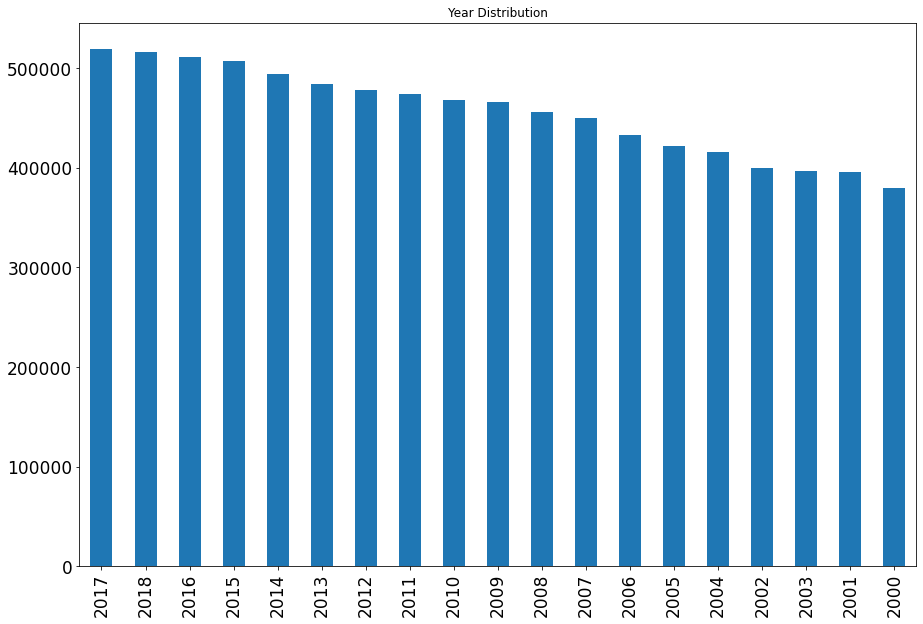

In [11]:
df['Year of diagnosis'].value_counts().plot(kind='bar',
                                            figsize=(15,10),
                                            fontsize=17,
                                            title='Year Distribution');


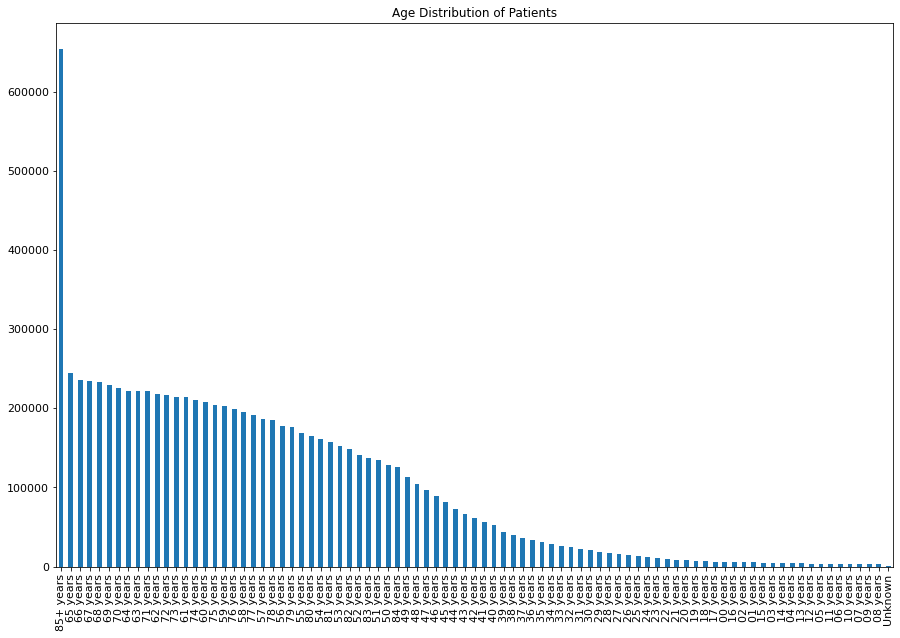

In [20]:
df['Age recode with single ages and 85+'].value_counts().plot(kind='bar',figsize=(15,10), 
                                                             title='Age Distribution of Patients',
                                                             fontsize=11,);

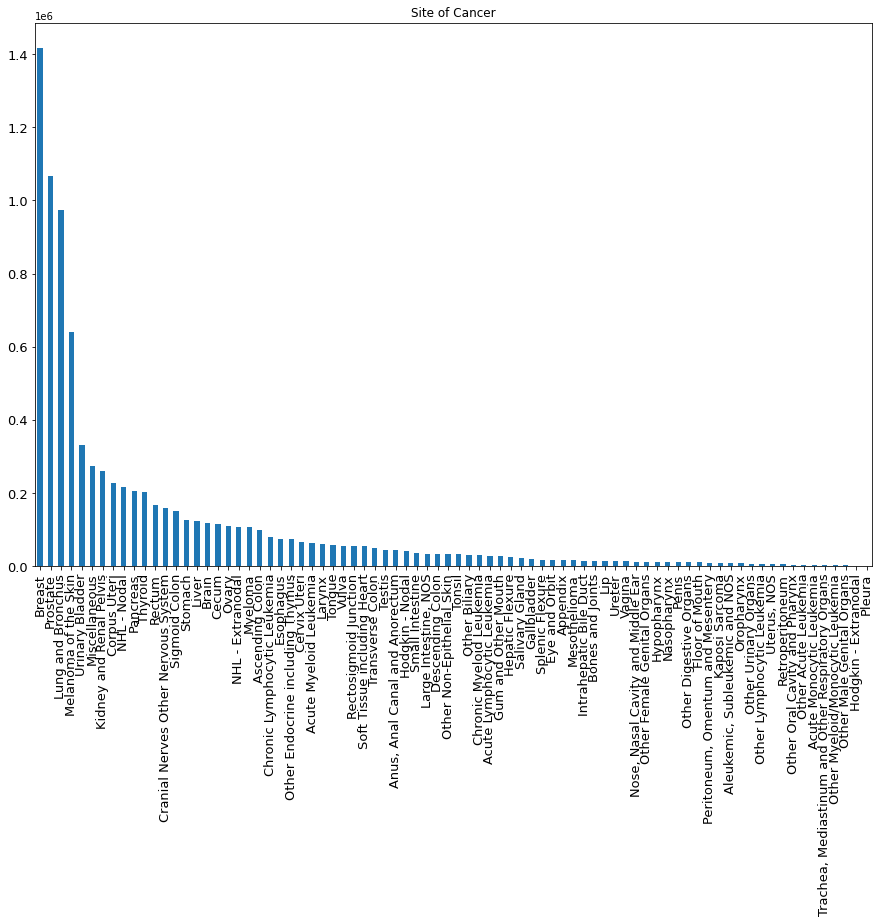

In [22]:
df['Site recode ICD-O-3/WHO 2008'].value_counts().plot(kind='bar',figsize=(15,10), 
                                                      title='Site of Cancer',
                                                      fontsize=13,);

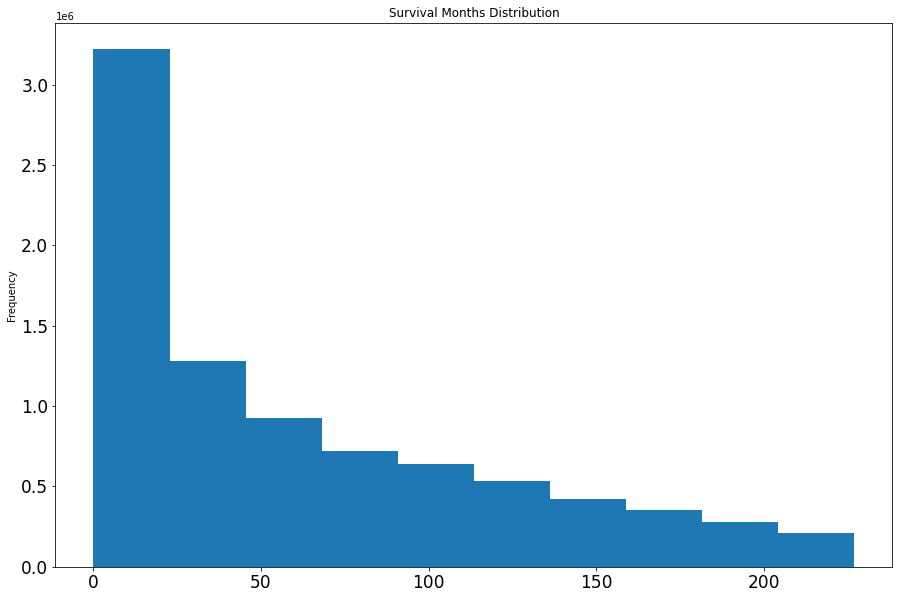

In [23]:
df['Survival months'].plot(kind='hist',figsize=(15,10), 
                                    title='Survival Months Distribution',
                                    fontsize=17,);

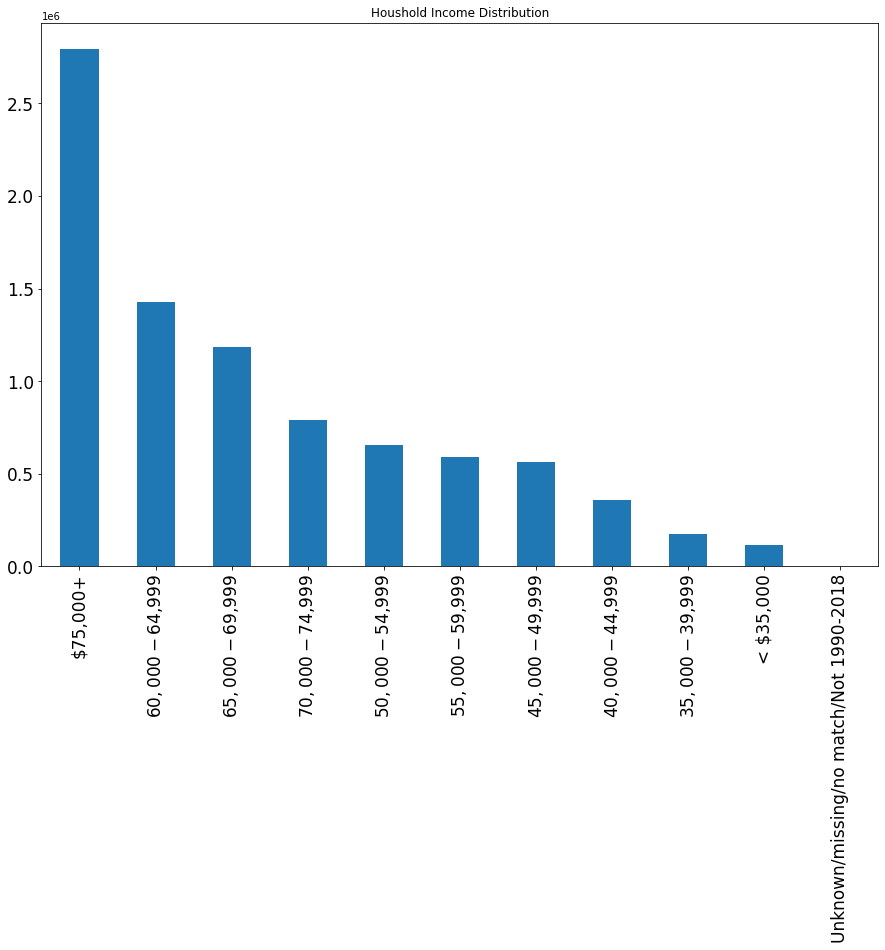

In [24]:
df['Median household income inflation adj to 2019'].value_counts().plot(kind='bar',figsize=(15,10), 
                                                                        title='Houshold Income Distribution',
                                                                        fontsize=17,);


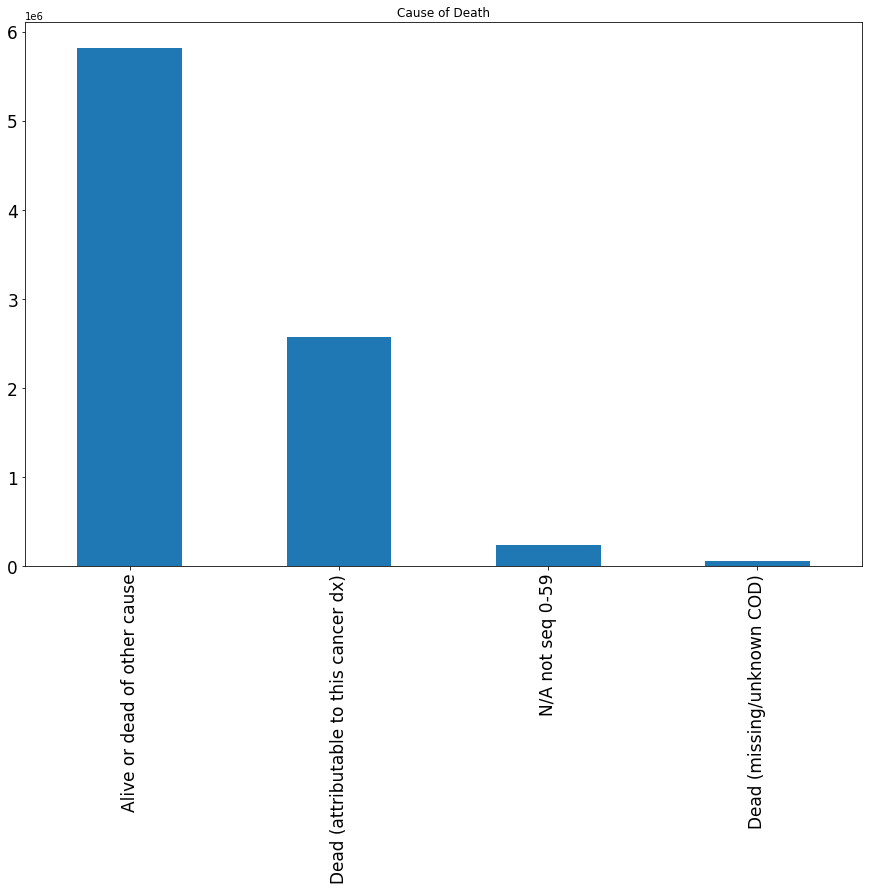

In [27]:
df['SEER cause-specific death classification'].value_counts().plot(kind='bar',figsize=(15,10), 
                                                                        title='Cause of Death',
                                                                        fontsize=17,);


## Change some data types

Most columns are of 'object' type. Then, some data types need to be modified. 

In [6]:
df.dtypes

Sex                                                     object
Year of diagnosis                                        int64
Race recode (W, B, AI, API)                             object
Origin recode NHIA (Hispanic, Non-Hisp)                 object
Site recode ICD-O-3/WHO 2008                            object
Behavior code ICD-O-3                                   object
Grade (thru 2017)                                       object
Laterality                                              object
Diagnostic Confirmation                                 object
SEER Combined Summary Stage 2000 (2004-2017)            object
Derived AJCC Stage Group, 6th ed (2004-2015)            object
Derived AJCC T, 6th ed (2004-2015)                      object
Derived AJCC N, 6th ed (2004-2015)                      object
Derived AJCC M, 6th ed (2004-2015)                      object
Reason no cancer-directed surgery                       object
RX Summ--Scope Reg LN Sur (2003+)                      

In [7]:
df['Survival months'] = pd.to_numeric(df['Survival months'],errors='coerce') #change survival months to a numeric type

Some columns are of object type by nature; examples include `Sex, Race, Laterality`. But, some columns can be interpreted as a mixed type. For example, `Age recode with single ages and 85+` column contains the information regarding the age of patient. However, if patients are older than 85, a single category is assigned to them. In other words, a patients with 85 years is assigned to the same category as the patient of age 92. For this reason, we tried two different approaches to solve the problem.
1. Try to change columns to numeric type as much as possible. For example, change the Age column to numeric value and ignore the fact the patients older than 85 are assigned the same age. 
2. Do not change data types and work directly with categorical data.

The two approaches are explored and compared in the following. Let's first change the columns as much as possible. 

## Change data types to numeric